# SVM

Máquinas de Vetores de Suporte (_Support vector machines (SVMs)_) representam uma classe de algoritmos de aprendizagem supervisionada particularmente poderosa e flexivel, que pode ser usada tanto para classificação quanto para regressão. Nesta aula, vamos abordar os conceitos por trás do SVM e sua aplicação para problemas de classificação.

Começando com os imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# usando as configurações padrões do seaborn para plotagem
import seaborn as sns; sns.set()

## Motivação do SVM

O SVM é um modelo discriminativo, i.e., tenta encontrar uma linha ou curva (para casos 2D) ou hyperplano ou _manifold_ (para casos com mais dimensões) que melhor separe as classes de um problema. 

Vamos ilustrar com um exemplo contendo duas classes de pontos bem separados:

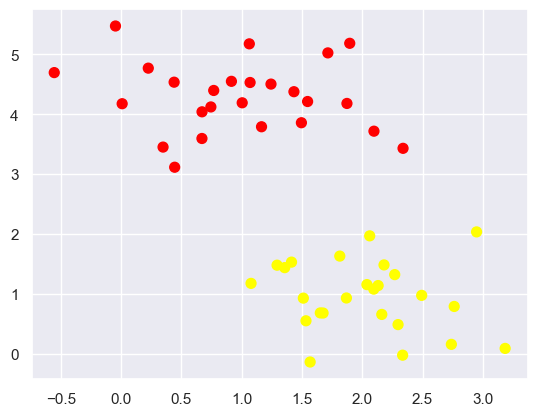

In [2]:
from sklearn.datasets._samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Um classificador linear poderia tentar traçar uma linha reta separando os 2 conjuntos, e consequentemente, criar um modelo de classificação. Nesse caso simples em 2D, é possível traçar essa reta à mão, mas logo surge um problema: existe mais de uma possível linha separando perfeitamente esses dados.

Podemos desenhar algumas:

(-1.0, 3.5)

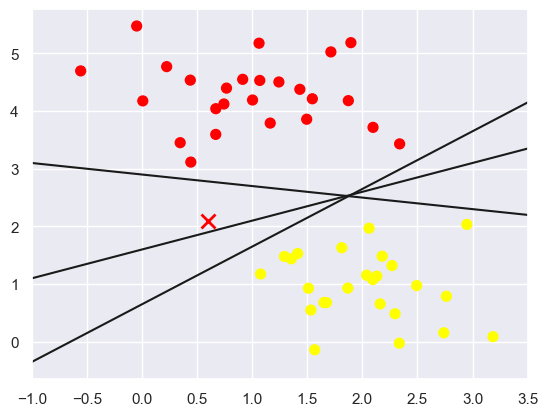

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)

Nesse caso, temos três retas bem diferentes, porém, discriminam perfeitamente essas amostras. Dependendo de qual linha você escolhe, uma nova amostra a ser classificada (ex: o "X" no plot) pode receber diferentes rótulos! Fica evidente que simplesmente "desenhar uma linha entre as classes" não é suficiente e precisamos de uma abordagem melhor.

## Maximizando as margens

SVMs oferecem uma alternativa para melhorar esse cenário. A idéia é a seguinte: em vez de simplesmente traçar uma reta com largura zero entre as 2 classes, podemos traçar também uma margem com uma certa dimensão, que vai até o ponto mais próximo. Veja um exemplo de como essa margem poderia ser:


(-1.0, 3.5)

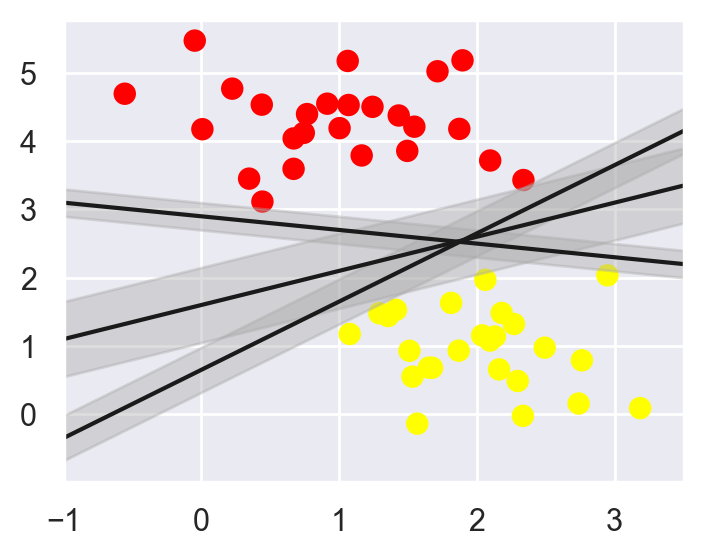

In [4]:
plt.figure(figsize=(4,3), dpi=200)
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

A reta que maximiza essa margem será a escolhida como modelo ótimo. Sendo assim, SVM pode ser visto como um exemplo de estimador que tenta maximizar o tamanho das margens.

## Treinando o SVM

Veremos o resultado após ajustar a reta a esses dados: para isso, usaremos o support vector classifier do já conhecido Scikit-Learn para treinar um modelo SVM. Utilizaremos um kernel linear e setaremos o parâmetro C para um número bem grande (esses significado desses parâmetros serão discutidos logo em seguida).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10) # criação do classificador
model.fit(X, y) # treinamento/otimização do classificador

SVC(C=10000000000.0, kernel='linear')

Para visualizar melhor o que está ocorrendo aqui, criaremos uma função que plota o limite de decisão:


In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plota a função de decisão para um classificador SVM 2D"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Cria um grid para avaliar o modelo
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plota a reta de decisão e as margens
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # destaca os vetores de suporte
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=2, facecolors='none',edgecolors='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

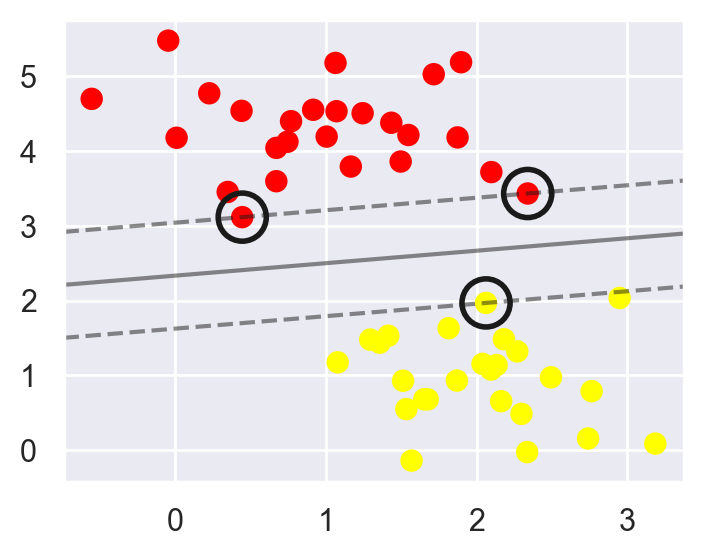

In [7]:
plt.figure(figsize=(4,3), dpi=200)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

Essa é a reta que maximiza as margens entre os 2 conjuntos de pontos. Note que poucas amostras de treinamento tocam nessa margem, e estão marcados com um circulo em volta. Esses pontos são os elementos pivot nesse ajuste, e são chamados de vetores de suporte, os quais dão o nome ao algoritmo. No Sckit-learn, a localização desses pontos são armazenadas no atributo support_vectors_.

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Um ponto chave no sucesso do SVM é que para classificação, apenas a posição dos vetores de suporte importam; quaisquer pontos além dessa margem que estejam do lado correto não modificam o ajuste. Tecnicamente, é por que esses demais pontos não contribuem para a função de _loss_ no ajuste do modelo, então suas posições não importam contanto que eles não cruzem as margens.

Podemos observar isso, por exemplo, se plotarmos o modelo aprendido a partir dos primeiros 60 pontos e a partir dos primeiros 120 pontos do dataset:

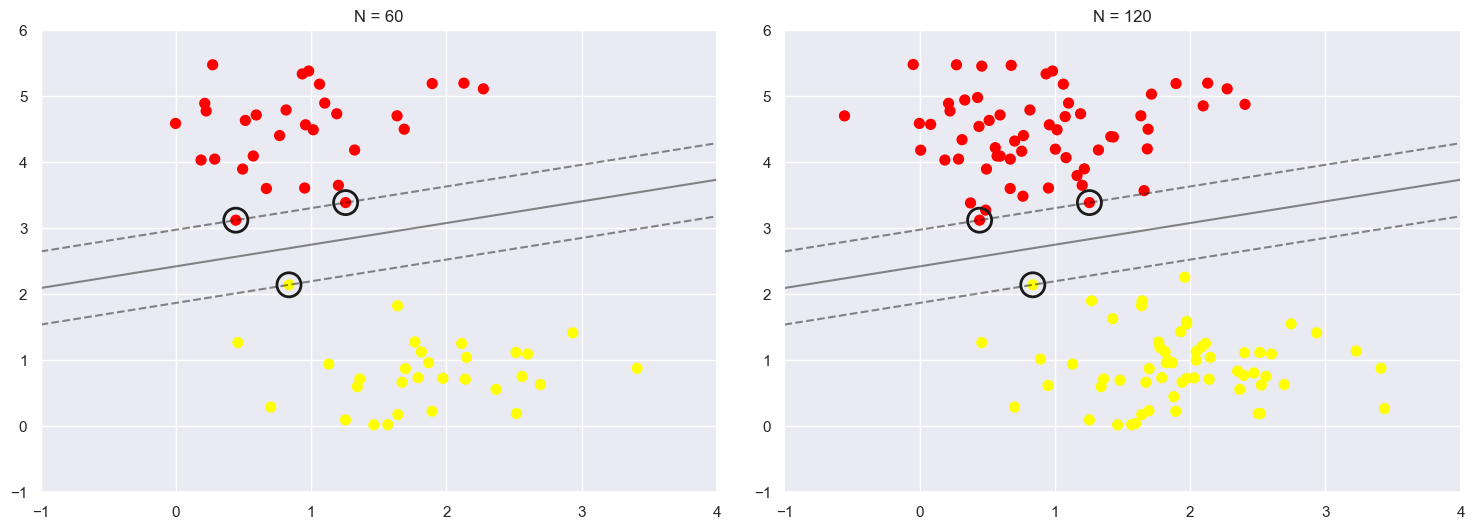

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

No plot da esquerda, vemos o painel e os vetores de suporte para as 60 amostras de treinamento. No painel a plot da direita, dobramos o número de amostras de treinamento, mas o modelo não mudou: os três vetores de suporte do plot da esquerda são os mesmos 3 vetores de suporte da direita. Essa insensividade em relação aos pontos mais distantes é um dos pontos fortes do SVM.


Podemos ver esse resultado de modo interativo:

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200], ax=fixed(None))

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200), value=10), Output()), _dom_classes…

<function __main__.plot_svm(N=10, ax=None)>

## Além das barreiras lineares: SVM com Kernel

SVM se torna extremamente poderoso quando combinado com kernels. A utilização de kernels permite projetar nossos dados em dimensões mais altas, definidas por polinômios e funções de base Gaussianas, e assim capazes de ajustar relacionamentos não lineares usando classificação linear.

Para termos uma ideia de como funciona, vamos olhar para um exemplo não linearmente separável.

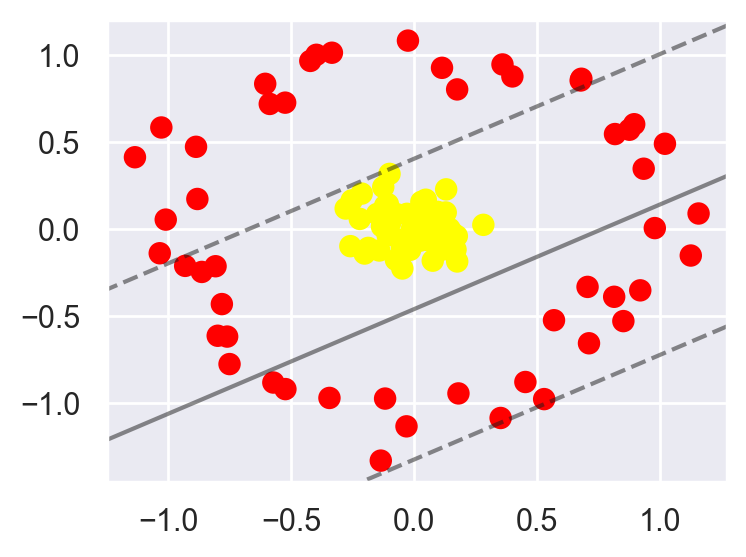

In [11]:
from sklearn.datasets._samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.figure(figsize=(4,3), dpi=200)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

Esse exemplo deixa claro que nenhum classificador linear é capaz de separar esses dados. No entanto, podemos utilizar mecanismos para projetar esses dados em um espaço de maior dimensão, de modo que um separador linear seja eficiente. Nesse exemplo, uma projeção simples seria computar a função de base radial centralizada no meio dos dados:

In [12]:
r = np.exp(-(X ** 2).sum(1))

Podemos visualizar essa dimensão extra usando um plot 3D:

In [13]:
#from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(4,4), dpi=200)
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    plt.show()

interact(plot_3D, elev=[-90,-45,-30,-0,30,45,90,135, 180], azip=(-180, 180),
         X=fixed(X), y=fixed(y))

interactive(children=(Dropdown(description='elev', index=4, options=(-90, -45, -30, 0, 30, 45, 90, 135, 180), …

<function __main__.plot_3D(elev=30, azim=30, X=array([[ 0.91859718, -0.35124279],
       [-1.13451168,  0.41302076],
       [ 0.02222982,  0.02111123],
       [-0.33425725,  1.01314335],
       [ 0.35883092,  0.9458683 ],
       [ 0.10545963,  0.07700396],
       [-1.00937672,  0.05494906],
       [ 0.17329657, -0.03942862],
       [ 0.81263287, -0.38818185],
       [ 0.52817305, -0.97569531],
       [ 0.815967  ,  0.54619873],
       [ 0.02910486,  0.15695077],
       [ 1.01889915,  0.49042703],
       [-0.79824166, -0.61196669],
       [-1.02728912,  0.58390611],
       [-0.07212988,  0.08650792],
       [-0.04471106, -0.05838076],
       [-0.25380303,  0.16536569],
       [-0.21327951,  0.20428516],
       [-1.03376448, -0.13824262],
       [-0.02406889,  0.07990077],
       [-0.11809808, -0.97260805],
       [-0.75018295, -0.77456337],
       [-0.80697648, -0.21276036],
       [-0.13564784, -1.32882091],
       [-0.93045498, -0.21060372],
       [ 0.07362523,  0.04875198],
       [

Podemos ver que nessa dimensão adicional, os dados se tornam linearmente separaveis com uma reta, digamos, com r=0.7.

Aqui nós precisamos escolher e ajustar cuidadosamente a nossa projeção: se não houvessemos centralizado a função de base radial na localização correta, não teriamos obtido um resultado os dados pudessem ser separados de forma tão clara. Em geral, escolher essa posição se torna um problema: temos que encontrar, de forma automática, a melhor função de base a ser usada.

Uma estratégia seria computar a função de base centralizada em cada amostra do dataset, e deixar o SVM peneirar o melhor resultado. Esse tipo de função de base é chamado de kernel, por ser baseada em relacionamentos de similaridade entre pares de amostras.

Um problema em potencial com essa estratégia - projetar M pontos em N dimensões - é que pode ser muito custoso, em termos computacionais, quando N cresce para valores muito grandes. No entanto, um truque conhecido como _kernel trick_, que ajusta a transformação dos dados de forma implícita, i.e., sem precisar construir todas as possíveis representações N-dimensionais da projeção do kernel! Esse truque é implementado dentro do SVM, e essa é uma das razões de o SVM ser tão poderoso.

No Scikit-Learn, podemos aplicar o SVM com kernel simplesmente mudando nosso kernel linear para kernel com função de base radial (_radial basis function (RBF)_), usando o parâmetro:

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

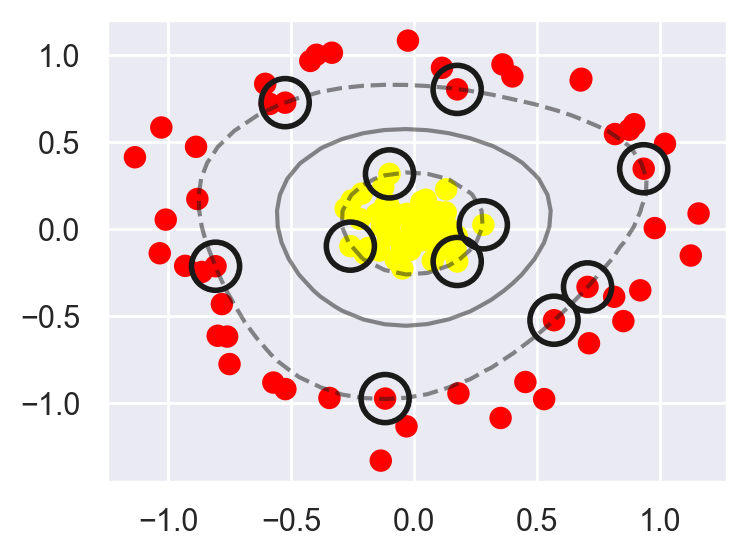

In [15]:
plt.figure(figsize=(4,3), dpi=200)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none')

## Melhorando o SVM: Margens suaves

Nossa discussão até agora considerou dados muito limpos, em que é possível definir uma linha de decisão muito clara. Mas e se nossos dados contêm sobreposição de classes? Podem ser, por exemplo, assim:


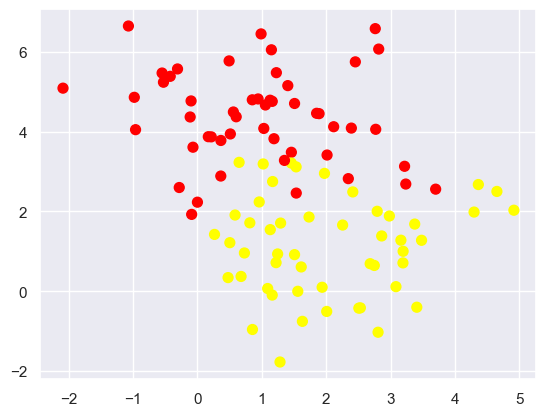

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Para lidar com casos assim, a implementação do SVM contém um 'fator de incertezas' que ``suaviza`` as margens, i.e., permite que alguns pontos 'rastegem' dentro da margem, se isso permitir um ajuste melhor. A rigidez da margem é controlada pelo hiperparâmetro $C$. Valores grandes de $C$ equivale a margens mais sólidas, em que as amostras não devem estar. Valores pequenos de $C$ correspondem a margens mais suaves, que podem abrigar alguns pontos.

O plot abaixo permite uma interpretação visual de como mudanças em $C$ afetam o ajuste final através da suavização da margem:

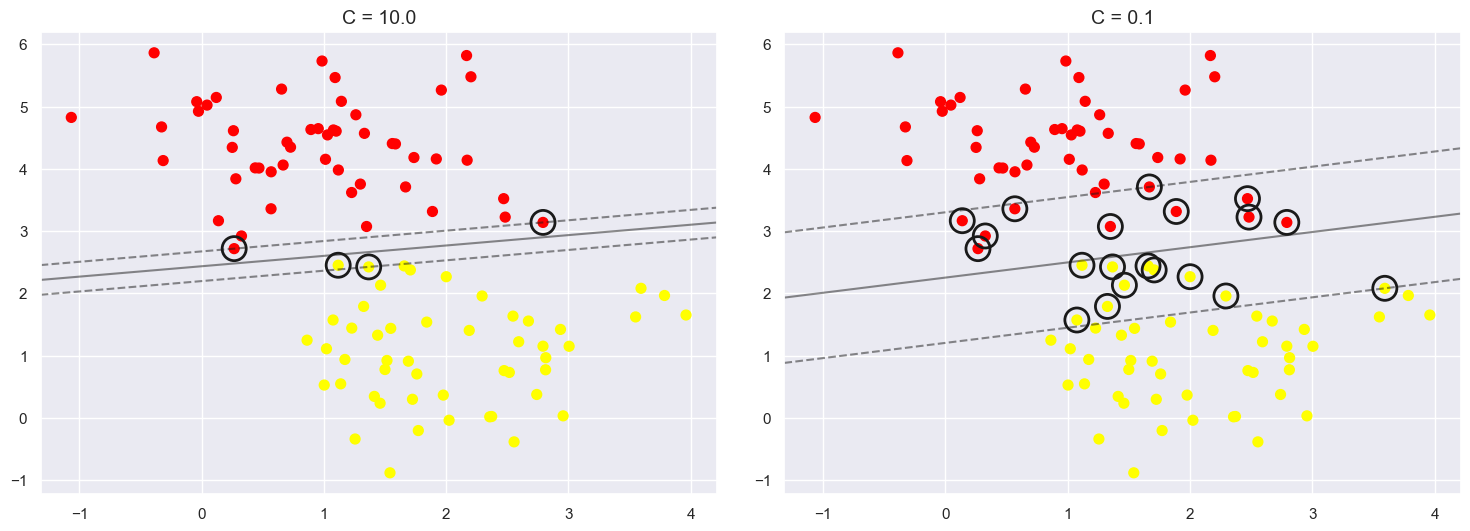

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none')
    axi.set_title('C = {0:.1f}'.format(C), size=14)

O valor ótimo de $C$ vai depender do dataset, e deve ser escolhido por validação cruzada, ou outros métodos.

## Examplo: Reconhecimento Facial

Como exemplo de SVM em ação, vamos dar uma olhada no problema de reconhecimento de faces. Nós usaremos o dataset rotulado _Faces in the Wild_, composto por milhares de fotos de várias figuras públicas. Podemos pegar esses dados usando Scikit-Learn:

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 62, 47)


Plotando algumas amostras para ter ideia do contexto em que estamos trabalhando:

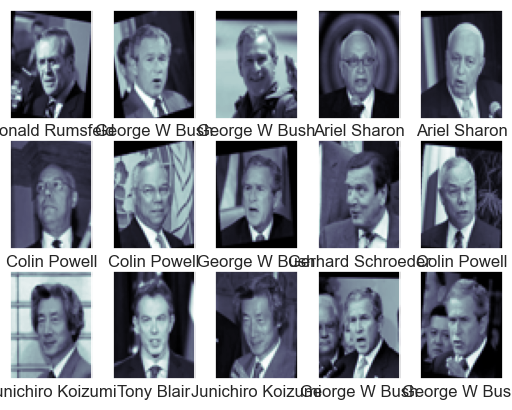

In [19]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagem contem 64x47 pixels (aproximadamente 3,000). Nós poderiamos simplesmente usar a intensidade de cada pixel como feature, mas geralmente, é mais eficiente usar alguns métodos de pré-processamente para extrair características mais significativas. Aqui, nós usaremos as técnicas _Principal Component Analysis (PCA)_ para extrair os 150 componentes mais relevantes e usá-los como features de cada amostra. Podemos fazer isso de modo simples juntando o pré-processamento e a classificação em um único _pipeline_:

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Para testar a saída de nosso classificador, vamos dividir os dados em treinamento e teste;

In [21]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finalmente, podemos usar uma validação cruzada com grid search (busca exaustiva) para explorar a combinação dos parâmetros. Aqui, ajustaremos $C$ (que controla a suavidade das bordas) e gamma (que controla o tamanho do kernel da função de base radial) para encontrar o melhor modelo:

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 55.3 s
Wall time: 35.1 s
{'svc__C': 1, 'svc__gamma': 0.001}


O valor ótimo fica entre os valores médios do nosso grid; se caisse nos extremos, seria interessante expandir esse grid para novos valores e nos certificarmos que escolhemos os valores ótimos.

Agora que temos esse modelo validado, podemos estimar os rótulos do conjunto de teste, os quais ainda não foram vistos pelo modelo.

In [23]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [24]:
print(faces.target_names[yfit[0]])
print(faces.target_names[yfit[0]].split()[-1])

Gerhard Schroeder
Schroeder


Vamos dar uma olhada a algumas das imagens com seus respectivos rótulos estimados:

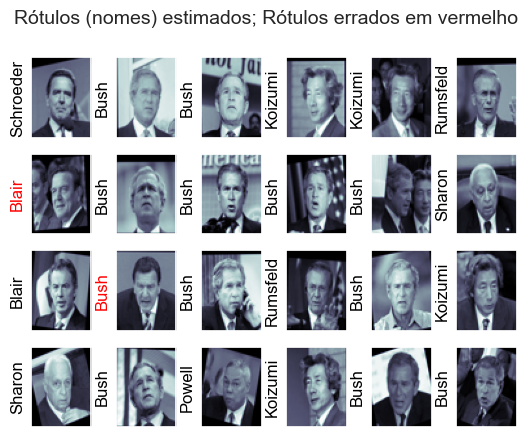

In [25]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Rótulos (nomes) estimados; Rótulos errados em vermelho', size=14);

Nessa pequena amostragem, o estimador ótimo classificou errado apenas uma face (Bush foi confundido com Blair). Podemos ter uma ideia melhor da performance do modelo usando o relatório de classificação, que lista as estatísticas para cada rótulo:

In [26]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.58      0.85      0.69        13
     Colin Powell       0.88      0.86      0.87        66
  Donald Rumsfeld       0.70      0.63      0.67        30
    George W Bush       0.89      0.89      0.89       139
Gerhard Schroeder       0.79      0.62      0.70        24
Junichiro Koizumi       0.81      1.00      0.89        17
       Tony Blair       0.77      0.74      0.75        31

         accuracy                           0.83       320
        macro avg       0.77      0.80      0.78       320
     weighted avg       0.83      0.83      0.83       320



Podemos mostrar também a matriz de confusão:

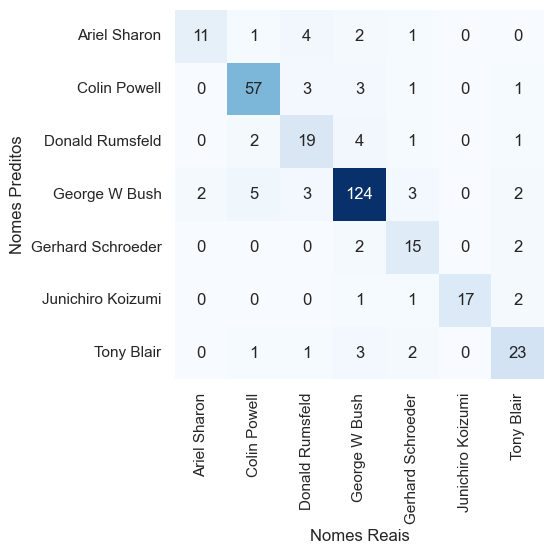

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names,cmap=plt.cm.Blues)
plt.xlabel('Nomes Reais')
plt.ylabel('Nomes Preditos')
plt.show()

Para casos reais de classificação de pessoas, onde o rosto já não esteja selecionado, precisariamos usar métodos mais eficientes de extração de características, ou então métodos mais poderosos, como _Deep Learning_.

## Sumarizando

SVM é uma técnica muito poderosa e foi uma das principais abordagens de aprendizado de máquinas por muito tempo, devido a diversos motivos:

- depende de poucos vetores de suporte para classificação, o que resulta em modelos compactos com baixo consumo de memória.
- uma vez treinado, a inferência é bem rápida.
- por ser afetado apenas por amostras próximas às margens, são eficientes para dados com alta dimensionalidade, inclusive para datasets com mais dimensões do que dados.
- a integração com os kernels faz o SVM muito versátil, capaz de se adaptar a muitos tipos de dados.

No entanto, SVM também tem varias desvantagens:

- a computação de um número muito grande de amostras pode ser proibitivo.
- os resultados são muito dependentes de uma escolha apropriada do parâmetro de suavização $C$. 
- os resultados não permitem uma interpretação probabilística. É possível computar o SVM probabilístico, porém, o processo é custoso.

Considerando esses pontos, existem modelos mais rápidos para problemas mais simples. No entanto, SVM pode providenciar excelentes resultados para determinados problemas em tempo hábil.

## Sugestão:

1. Baixar alguns datasets de classificação do repositório [Real-World datasets](https://scikit-learn.org/stable/datasets/real_world.html) do Scikit-Learn e classificá-los usando SVM. Verificar se funciona melhor com SVM linear ou com kernel RBF, e testar diferentes valores de $C$.